In [40]:
import os, sys, pandas as pd, wfdb, tqdm, pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt, librosa
from scipy.signal import spectrogram

In [2]:
sys.path = ['/N/project/waveform_mortality/rmahawar/'] + sys.path

In [3]:
from data_utils import *

In [4]:
root_dir = '/N/project/waveform_mortality/rmahawar/'

In [5]:
df = pd.read_csv(os.path.join(root_dir, 'In_Hospital_Mortality_Regression/waveform_mortality.csv'))

In [6]:
len(df)

10257

In [7]:
df['DEATH_T0'] = df['DEATH_T0'].fillna(999999).astype('uint32')

In [8]:
df.head()

,SUBJECT_ID,ICUSTAY_ID,INTIME,OUTTIME,deathtime,DEATH_T0
0,29299,206514,2192-12-06T20:06:11,2192-12-11T16:43:54,NaN,999999
1,27338,230135,2125-01-05T23:31:46,2125-01-18T15:56:59,2125-01-18T15:12:00,304
2,30509,251795,2113-07-21T19:04:23,2113-07-28T21:21:38,NaN,999999
3,32701,260388,2139-04-01T16:19:52,2139-04-07T18:04:56,NaN,999999
4,32420,291291,2110-06-27T15:56:30,2110-07-01T18:52:22,2110-07-04T12:00:00,165


In [10]:
window_start_time = datetime.strptime('2192-12-06T20:06:11', '%Y-%m-%dT%H:%M:%S')
window_end_time = window_start_time + timedelta(hours= 1)
test = get_waveform_data(29299, (window_start_time, window_end_time))

In [46]:
len(test[0][0])

450000

In [17]:
test[0][0][:50]

array([0.3       , 0.31372549, 0.32941176, ..., 0.18431373, 0.20980392,
       0.2       ])

In [20]:
test[0][0][np.where(test[0][0] == None)]

array([], dtype=float64)

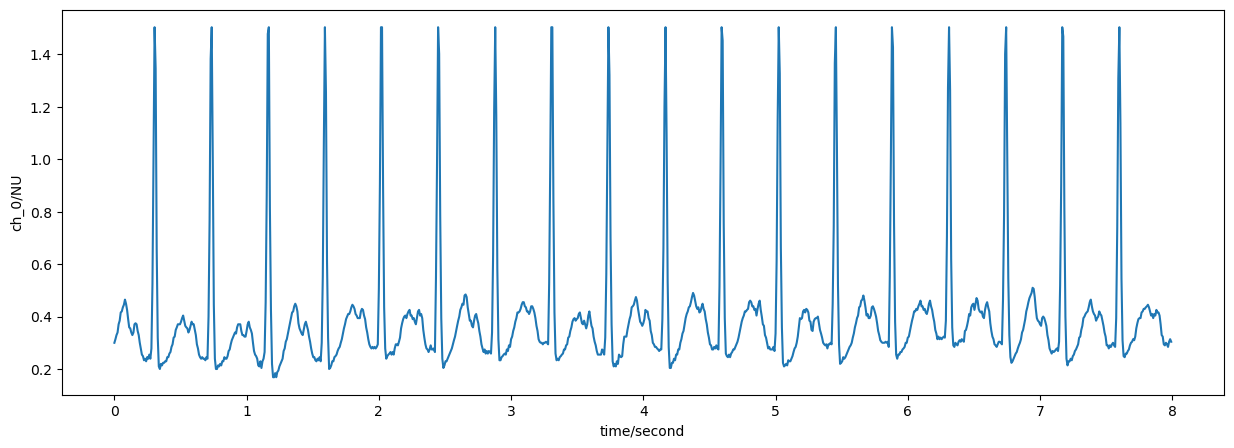

In [31]:
wfdb.plot_items(signal = test[0][0][: 1000], time_units= 'seconds', fs= 125, figsize= (15,5))

In [41]:
f, t, Sxx = spectrogram(test[0][0], fs= 125)

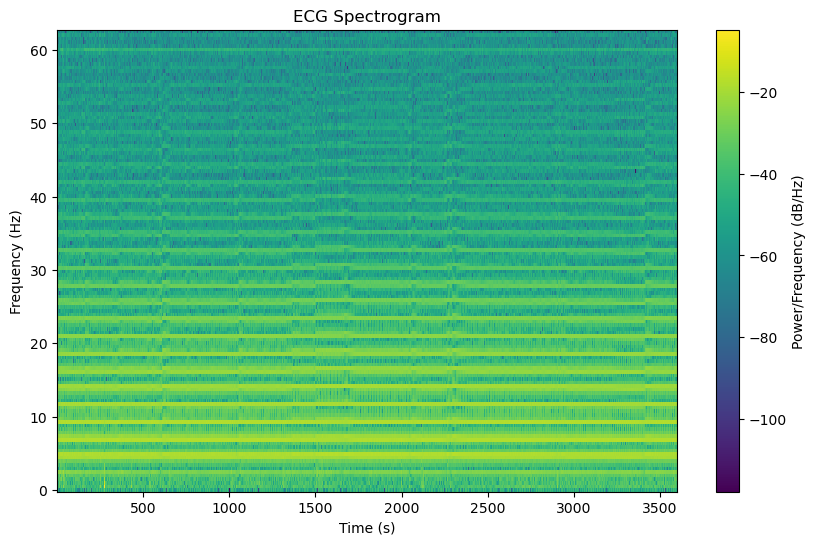

In [42]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='auto', cmap='viridis')
plt.title('ECG Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

In [36]:
test_stft = librosa.stft(test[0][0], n_fft= 1024, hop_length= 512)

In [37]:
len(test_stft)

513

/N/slate/rmahawar/anaconda3/envs/ronak/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


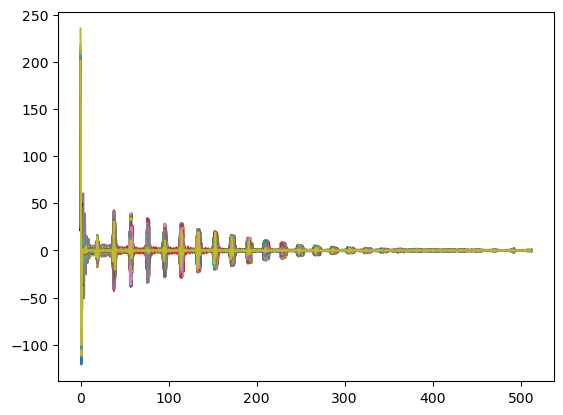

In [45]:
plt.plot(test_stft)

In [ ]:
patients = give_patients_with_wave_threshold(df, signal= 'II', num_workers= 64)

In [ ]:
len(patients)

2403

In [19]:
(df[df['SUBJECT_ID'].isin(patients)]['DEATH_T0'] == 999999).sum()

2047

In [16]:
patients_avr = give_patients_with_wave_threshold(df, signal= 'AVR', num_workers= 64)

100%|██████████| 10257/10257 [00:00<00:00, 1354692.70it/s]


In [17]:
len(patients_avr)

1062

In [18]:
(df[df['SUBJECT_ID'].isin(patients_avr)]['DEATH_T0'] != 999999).sum()

148

In [19]:
patients_v = give_patients_with_wave_threshold(df, signal= 'V', num_workers= 64)

100%|██████████| 10257/10257 [00:00<00:00, 1731714.21it/s]


In [20]:
len(patients_v)

1654

In [21]:
(df[df['SUBJECT_ID'].isin(patients_v)]['DEATH_T0'] != 999999).sum()

241

In [12]:
pdf_1hr = get_time_distribution_parallel(df, num_workers= 64)

100%|██████████| 10257/10257 [00:00<00:00, 1176658.17it/s]


In [13]:
data = [(key, len([x  for x in val if x > 0.5])) for key, val in pdf_1hr.items()]

In [14]:
data

[('II', 2403),
 ('AVR', 1062),
 ('V', 1654),
 ('RESP', 1288),
 ('PLETH', 1558),
 ('PAP', 111),
 ('ART', 31),
 ('CVP', 49),
 ('ABP', 684),
 ('I', 49),
 ('PLETH L', 12),
 ('MCL', 55),
 ('III', 176),
 ('AVL', 10),
 ('PLETH R', 5),
 ('LAP', 1),
 ('P1', 0),
 ('AVF', 40),
 ('MCL1', 156),
 ('AOBP', 2),
 ('RAP', 0),
 ('ECG', 0),
 ('aVF', 1),
 ('ICP', 3),
 ('aVL', 1),
 ('aVR', 13),
 ('CO2', 1),
 ('UAP', 1),
 ('BAP', 1)]

(array([269., 140., 142., 171., 804.,   0.,   2.,   0.,   3.,   5.]),
 array([2.77777778e-04, 2.00250000e-01, 4.00222222e-01, 6.00194444e-01,
        8.00166667e-01, 1.00013889e+00, 1.20011111e+00, 1.40008333e+00,
        1.60005556e+00, 1.80002778e+00, 2.00000000e+00]),
 <BarContainer object of 10 artists>)

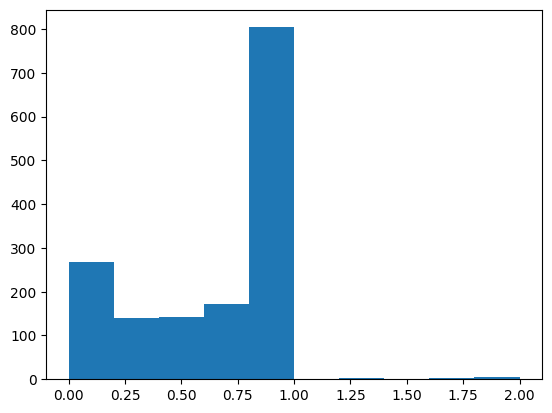

In [15]:
plt.hist(pdf_1hr['AVR'])

(array([126.,  30.,  15.,   9.,   6.,   9.,  11.,  14.,  20., 122.]),
 array([2.77777778e-04, 1.00250000e-01, 2.00222222e-01, 3.00194444e-01,
        4.00166667e-01, 5.00138889e-01, 6.00111111e-01, 7.00083333e-01,
        8.00055556e-01, 9.00027778e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

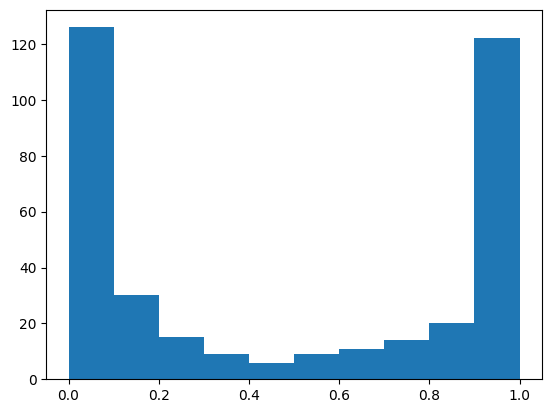

In [20]:
plt.hist(pdf_1hr['III'])

In [16]:
len(pdf_1hr)

29

In [22]:
temp = [len(x) for _, x in pdf_1hr.items()]
max(temp)

3441

In [17]:
pdf_1hr.keys()

dict_keys(['II', 'AVR', 'V', 'RESP', 'PLETH', 'PAP', 'ART', 'CVP', 'ABP', 'I', 'PLETH L', 'MCL', 'III', 'AVL', 'PLETH R', 'LAP', 'P1', 'AVF', 'MCL1', 'AOBP', 'RAP', 'ECG', 'aVF', 'ICP', 'aVL', 'aVR', 'CO2', 'UAP', 'BAP'])

In [27]:
records = get_record_list(db_dir= os.path.join(base_db, patient_dir))


/N/project/waveform_mortality/shared/datasets/waveform_datasets/mimic-iii-waveform-database-1.0-full/mimic3wdb-matched-1.0.physionet.org/matched/matched/p02/p029299/RECORDS


In [28]:
records

['p029299-2192-11-14-21-18',
 'p029299-2192-12-06-20-01',
 'p029299-2192-12-06-20-01n',
 'p029299-2192-12-07-16-13',
 'p029299-2192-12-07-16-13n',
 '3016206_0001',
 '3016206_0002',
 '3016206_0003',
 '3016206_0004',
 '3016206_0005',
 '3016206_0006',
 '3016206_0007',
 '3016206_0008',
 '3364831_0001',
 '3364831_0002',
 '3364831_0003',
 '3364831_0004',
 '3364831_0005',
 '3364831_0006',
 '3364831_0007',
 '3495420_0001',
 '3495420_0002']

### Can we speed this dataloading up using threads?

In [ ]:
with open('pdf_1hr.pkl', 'wb') as file:
    pickle.dump(pdf_1hr, file)

In [ ]:
filtered_df.to_csv('waveform_mortality.csv', index= False)

### Initially we had 46374 patients cohort. But only 10,257 patients have their waveform recorded!

In [63]:
len(filtered_df[filtered_df['DEATH_T0'] != 999999])

1421

### 1421/10257 patients died!

In [24]:
clinical_data_path = '/N/project/waveform_mortality/shared/datasets/clinical_datasets/mimic-iii-clinical-database-1.4/'

In [25]:
df_admissions = pd.read_csv(os.path.join(clinical_data_path, 'ADMISSIONS.csv'))

In [29]:
df_admissions['DIAGNOSIS'] = df_admissions['DIAGNOSIS'].astype(str)

In [41]:
donors = set()
for index, val in enumerate(df_admissions['DIAGNOSIS'].values.tolist()):
    if 'organ' in val.lower():
        donors.add(df_admissions.loc[index]['SUBJECT_ID'])

In [42]:
print(f'Number of organ donors in admissions table = {len(donors)}')

Number of organ donors in admissions table = 54


In [27]:
len(df_admissions['SUBJECT_ID'].unique())

46520